In [39]:
import networkx as nx
import pandas as pd
import os
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt

In [40]:
leadership_path = r'C:\Projects\connecteddatahub\data\cleaned_dataframes\master_leadershipdata.csv'
data_path = r'C:\Projects\connecteddatahub\data'
leadership_df = pd.read_csv(leadership_path)
print(leadership_df.columns)

Index(['Year', 'Name', 'Position', 'Institution', 'SubInstitution',
       'Education', 'FixedPosition', 'Seniority', 'Designation',
       'AffiliationId', 'carnegie_id', 'SystemId', 'RawName', 'RawInstitution',
       'RawPosition', 'FirstName', 'MiddleName', 'LastName', 'NickName',
       'SuffixName', 'PrefixName', 'MiddleInitials', 'RawName4Match',
       'LeaderId'],
      dtype='object')


In [41]:
board_df =  leadership_df[leadership_df['FixedPosition'] == 'Board Member']
print(board_df.shape)

(54153, 24)


In [ ]:
def compute_edge_weakness(G, alpha=0.7, beta=0.3):
    """Compute composite edge weakness using neighborhood overlap and betweenness."""
    # neighborhood overlap
    overlap = {}
    for u, v in G.edges():
        Nu = set(G.neighbors(u)) - {v}
        Nv = set(G.neighbors(v)) - {u}
        inter = len(Nu & Nv)
        denom = len(Nu | Nv)
        overlap_val = inter / (denom - 2) if denom > 2 else 0.0
        overlap[(u, v)] = overlap_val
    nx.set_edge_attributes(G, overlap, "overlap")

    # betweenness
    ebc = nx.edge_betweenness_centrality(G, normalized=True)
    nx.set_edge_attributes(G, ebc, "betweenness")

    # combined weakness score
    weakness = {
        (u, v): alpha * (1 - d.get("overlap", 0)) + beta * d.get("betweenness", 0)
        for u, v, d in G.edges(data=True)
    }
    nx.set_edge_attributes(G, weakness, "weakness")

    return weakness

def add_edge_weakness(yearly_edges_df, nodes_df, alpha=0.7, beta=0.3):
    """Attach computed weakness to each edge in the dataframe."""
    edges_with_weakness = []
    for year, group in yearly_edges_df.groupby("Year"):
        G = nx.Graph()
        G.add_nodes_from(nodes_df["Id"].unique())

        # canonical edge order: (min, max)
        for _, row in group.iterrows():
            u, v = sorted((row["AffiliationId_1"], row["AffiliationId_2"]))
            G.add_edge(u, v, weight=row["WeightNorm"])

        weakness = compute_edge_weakness(G, alpha=alpha, beta=beta)
        
        # Ensure canonical ordering in the dataframe too
        df_w = pd.DataFrame([
            {
                "AffiliationId_1": min(u, v),
                "AffiliationId_2": max(u, v),
                "Weakness": w,
                "Year": year
            }
            for (u, v), w in weakness.items()
        ])
        edges_with_weakness.append(df_w)

    return pd.concat(edges_with_weakness, ignore_index=True)



In [43]:
def compute_edge_weakness(G, alpha=0.7, beta=0.3):
    """Compute composite edge weakness using neighborhood overlap and betweenness."""
    # neighborhood overlap
    overlap = {}
    for u, v in G.edges():
        Nu = set(G.neighbors(u)) - {v}
        Nv = set(G.neighbors(v)) - {u}
        inter = len(Nu & Nv)
        denom = len(Nu | Nv)
        overlap_val = inter / (denom - 2) if denom > 2 else 0.0
        overlap[(u, v)] = overlap_val
    nx.set_edge_attributes(G, overlap, "overlap")

    # betweenness
    ebc = nx.edge_betweenness_centrality(G, normalized=True)
    nx.set_edge_attributes(G, ebc, "betweenness")

    # combined weakness score
    weakness = {
        (u, v): alpha * (1 - d.get("overlap", 0)) + beta * d.get("betweenness", 0)
        for u, v, d in G.edges(data=True)
    }
    nx.set_edge_attributes(G, weakness, "weakness")

    return weakness

def add_edge_weakness(yearly_edges_df, nodes_df, alpha=0.7, beta=0.3):
    """Attach computed weakness to each edge in the dataframe."""
    edges_with_weakness = []
    for year, group in yearly_edges_df.groupby("Year"):
        G = nx.Graph()
        G.add_nodes_from(nodes_df["Id"].unique())

        # canonical edge order: (min, max)
        for _, row in group.iterrows():
            u, v = sorted((row["AffiliationId_1"], row["AffiliationId_2"]))
            G.add_edge(u, v, weight=row["WeightNorm"])

        weakness = compute_edge_weakness(G, alpha=alpha, beta=beta)
        
        # Ensure canonical ordering in the dataframe too
        df_w = pd.DataFrame([
            {
                "AffiliationId_1": min(u, v),
                "AffiliationId_2": max(u, v),
                "Weakness": w,
                "Year": year
            }
            for (u, v), w in weakness.items()
        ])
        edges_with_weakness.append(df_w)

    return pd.concat(edges_with_weakness, ignore_index=True)




# Identify person-level interlocks (same year, different institutions)
interlock_rows = []

for (year, first, last), person_data in board_df.groupby(["Year", "FirstName", "LastName"]):
    affiliations = (
        person_data[["AffiliationId", "Institution", "SystemId"]]
        .drop_duplicates()
    )

    if len(affiliations) <= 1:
        continue

    for (id1, inst1, sys1), (id2, inst2, sys2) in combinations(affiliations.values, 2):
        # Skip if both belong to the same system
        if pd.notna(sys1) and pd.notna(sys2) and sys1 == sys2:
            continue

        # undirected: canonical ordering by AffiliationId
        if id1 > id2:
            id1, id2 = id2, id1
            inst1, inst2 = inst2, inst1
            sys1, sys2 = sys2, sys1

        interlock_rows.append({
            "Year": year,
            "FirstName": first,
            "LastName": last,
            "AffiliationId_1": id1,
            "Institution_1": inst1,
            "SystemId_1": sys1,
            "AffiliationId_2": id2,
            "Institution_2": inst2,
            "SystemId_2": sys2,
        })

person_interlocks_df = pd.DataFrame(interlock_rows)

# Institution-level interlocks (raw counts)
yearly_edges_df = (
    person_interlocks_df
    .groupby(["Year", "AffiliationId_1", "Institution_1",
              "AffiliationId_2", "Institution_2"], as_index=False)
    .size()
    .rename(columns={"size": "InterlockCount"})
)

# Board sizes per (Year, AffiliationId)
board_sizes = (
    board_df.groupby(["Year", "AffiliationId"])["Name"]
    .nunique()
    .reset_index(name="BoardSize")
)

# Attach board sizes to each side of the edge
yearly_edges_df = (
    yearly_edges_df
    .merge(
        board_sizes.rename(columns={"AffiliationId": "AffiliationId_1", "BoardSize": "BoardSize_1"}),
        on=["Year", "AffiliationId_1"],
        how="left"
    )
    .merge(
        board_sizes.rename(columns={"AffiliationId": "AffiliationId_2", "BoardSize": "BoardSize_2"}),
        on=["Year", "AffiliationId_2"],
        how="left"
    )
)

# Normalized weight = InterlockCount / (BoardSize_1 + BoardSize_2)
# Cast to float to avoid integer division
denom = yearly_edges_df["BoardSize_1"].astype(float) + yearly_edges_df["BoardSize_2"].astype(float)
yearly_edges_df["WeightNorm"] = yearly_edges_df["InterlockCount"].astype(float) / denom

# # Gephi exports
# edges_df = (
#     yearly_edges_df
#     .rename(columns={
#         "AffiliationId_1": "Source",
#         "AffiliationId_2": "Target",
#         "WeightNorm": "Weight"
#     })[["Source", "Target", "Weight", "Year"]]
# )

nodes_df = (
    board_df[["AffiliationId", "Institution", "SystemId"]]
    .drop_duplicates()
    .rename(columns={
        "AffiliationId": "Id",
        "Institution": "Label",
    })[["Id", "Label", "SystemId"]]
)

#work the weakness of edges into the data
# --- Compute and attach edge weakness per year ---

yearly_edges_df[["AffiliationId_1", "AffiliationId_2"]] = np.sort(
    yearly_edges_df[["AffiliationId_1", "AffiliationId_2"]].values, axis=1
)

weakness_df = add_edge_weakness(yearly_edges_df, nodes_df)



# Merge weakness back into yearly_edges_df
yearly_edges_df = (
    yearly_edges_df.merge(
        weakness_df.rename(columns={"Source": "AffiliationId_1", "Target": "AffiliationId_2"}),
        on=["AffiliationId_1", "AffiliationId_2", "Year"],
        how="left"
    )
)

# Derive edges_df without dropping any columns
edges_df = (
    yearly_edges_df
    .assign(
        Source=lambda df: df["AffiliationId_1"],
        Target=lambda df: df["AffiliationId_2"],
        Weight=lambda df: df["WeightNorm"]
    )
)


In [44]:

person_interlocks_df.to_csv(os.path.join(data_path, 'interlocks', 'interlock_names.csv'), index = False)
yearly_edges_df.to_csv(os.path.join(data_path, 'interlocks', 'yearly_interlocks.csv'), index = False)

In [45]:
edges_df.to_csv(os.path.join(data_path, 'interlocks', 'interlock_edges.csv'), index=False)
nodes_df.to_csv(os.path.join(data_path, 'interlocks', 'interlock_nodes.csv'), index=False)


=== Yearly Interlock Totals ===
 Year  TotalInterlocks
 1999              155
 2000              220
 2002              149
 2005              150
 2007              151
 2008              164
 2009              156
 2010              124
 2011              116
 2013              122
 2018              117

Global Graph Stats:
Nodes: 251
Edges: 481
Density: 0.0153



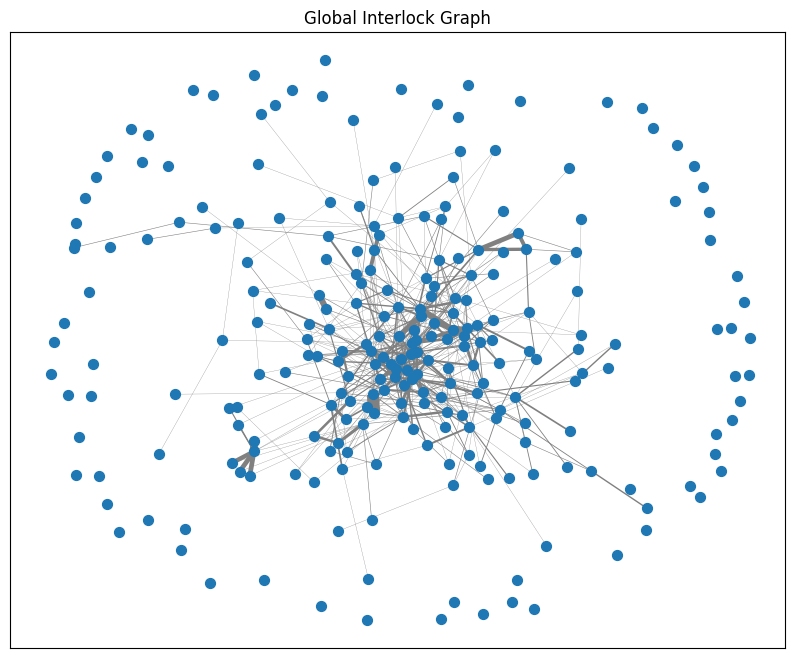

=== Year 1999 ===
Nodes: 204
Edges: 113
Density: 0.0055



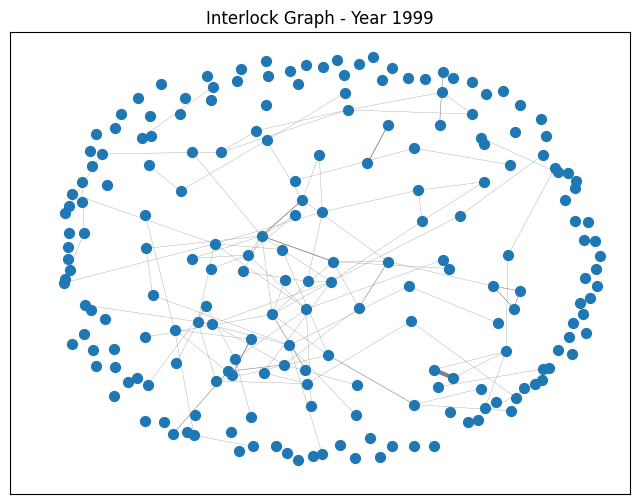

=== Year 2000 ===
Nodes: 212
Edges: 136
Density: 0.0061



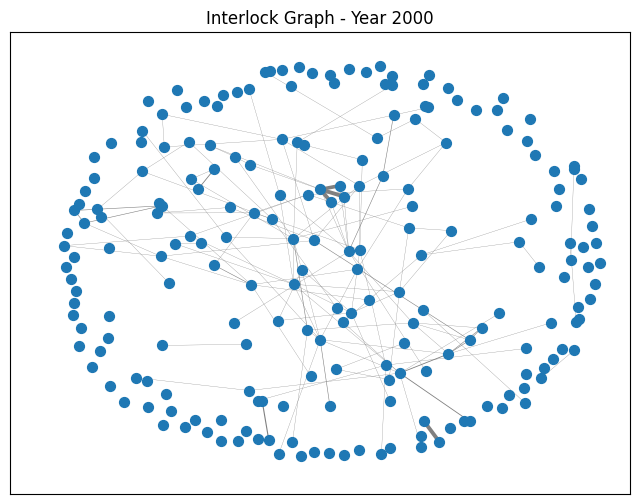

=== Year 2002 ===
Nodes: 216
Edges: 108
Density: 0.0047



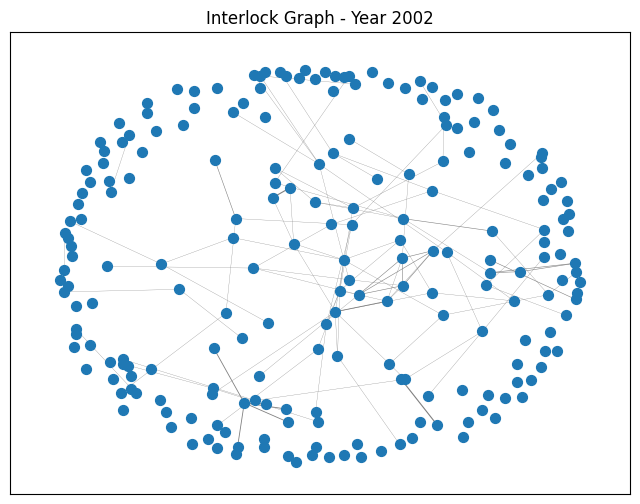

=== Year 2005 ===
Nodes: 206
Edges: 121
Density: 0.0057



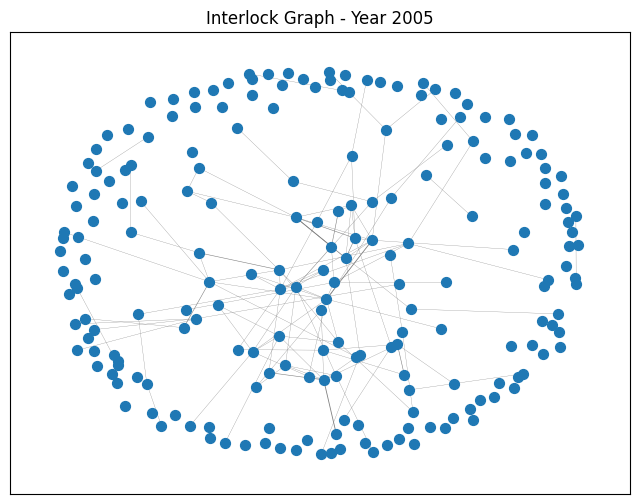

=== Year 2007 ===
Nodes: 208
Edges: 122
Density: 0.0057



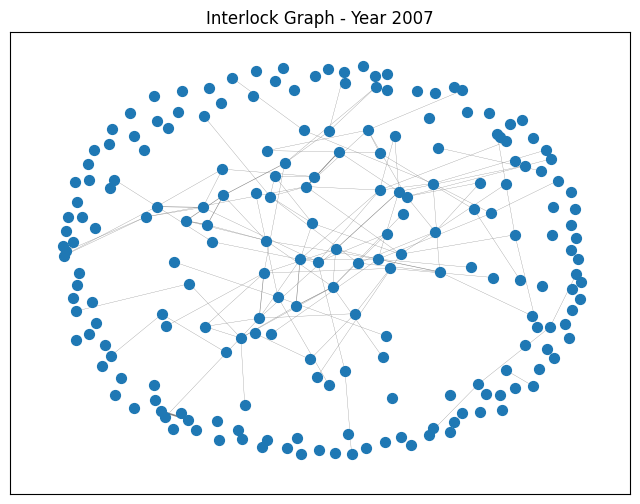

=== Year 2008 ===
Nodes: 217
Edges: 136
Density: 0.0058



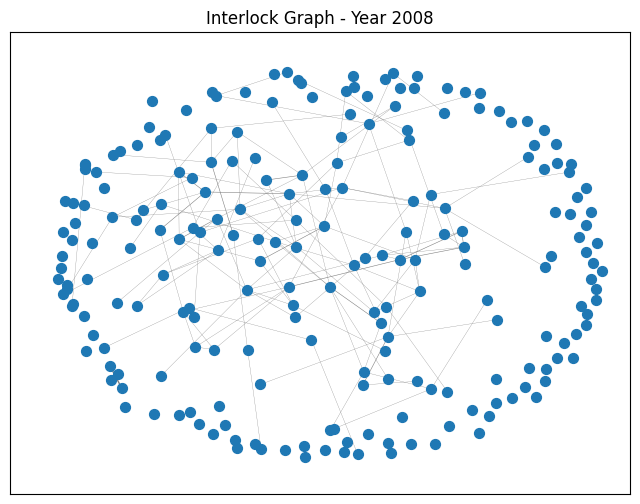

=== Year 2009 ===
Nodes: 203
Edges: 124
Density: 0.0060



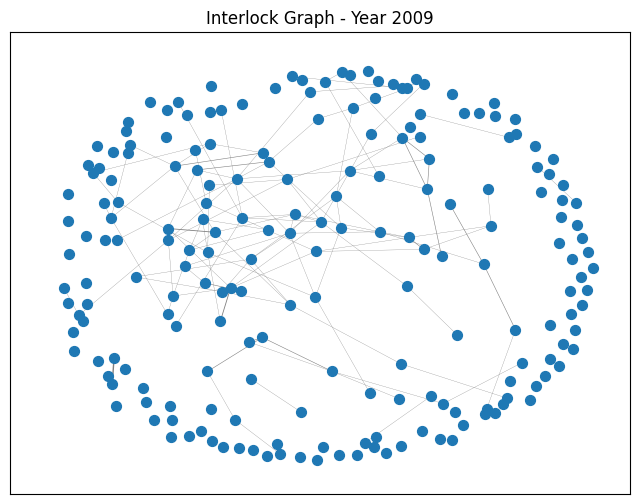

=== Year 2010 ===
Nodes: 185
Edges: 108
Density: 0.0063



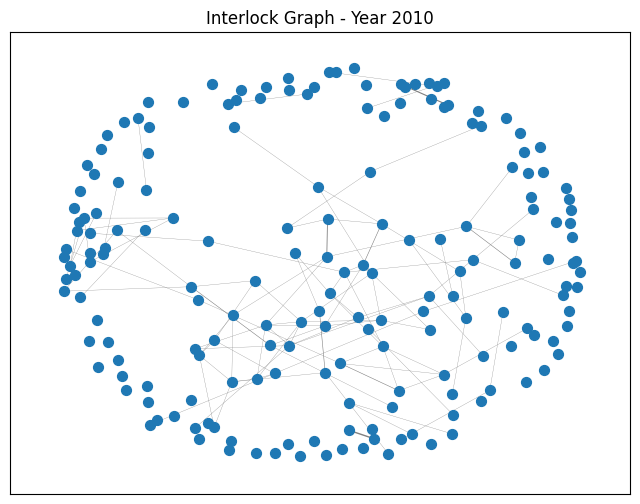

=== Year 2011 ===
Nodes: 177
Edges: 102
Density: 0.0065



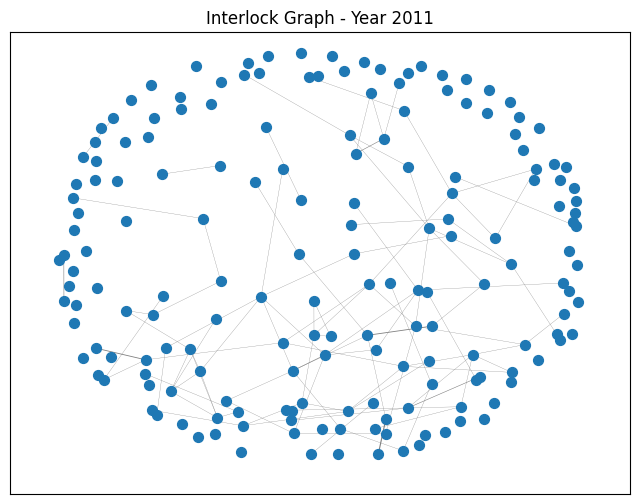

=== Year 2013 ===
Nodes: 170
Edges: 109
Density: 0.0076



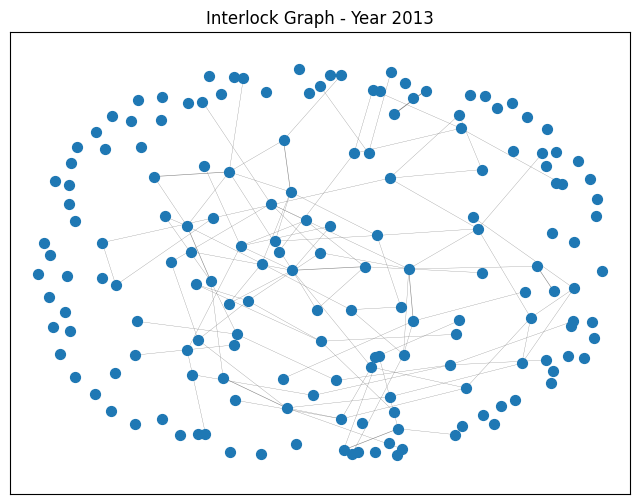

=== Year 2018 ===
Nodes: 173
Edges: 92
Density: 0.0062



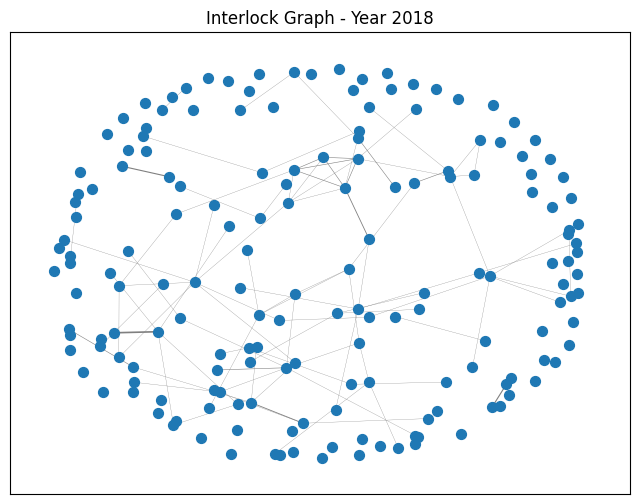

In [46]:
# Yearly totals (unchanged)
yearly_counts = (
    yearly_edges_df.groupby("Year")["InterlockCount"].sum().reset_index()
    .rename(columns={"InterlockCount": "TotalInterlocks"})
)

print("=== Yearly Interlock Totals ===")
print(yearly_counts.to_string(index=False))
print()

# Global interlocks network
G_global = nx.Graph()

# add all institutions as nodes (so isolated schools appear even with no interlocks)
G_global.add_nodes_from(
    nodes_df["Id"].dropna().astype(str).unique().tolist()
)

# only add valid edges (both endpoints present; weight > 0)
edge_rows = yearly_edges_df.dropna(subset=["AffiliationId_1", "AffiliationId_2"]).copy()
for _, row in edge_rows.iterrows():
    u = str(row["AffiliationId_1"])
    v = str(row["AffiliationId_2"])
    w = int(row["InterlockCount"]) if pd.notna(row["InterlockCount"]) else 0
    if w <= 0 or u == v:
        continue
    if G_global.has_edge(u, v):
        G_global[u][v]["weight"] += w
    else:
        G_global.add_edge(u, v, weight=w)

print("Global Graph Stats:")
print(f"Nodes: {G_global.number_of_nodes()}")
print(f"Edges: {G_global.number_of_edges()}")
print(f"Density: {nx.density(G_global):.4f}")
print()

# Plot Global Graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_global, k=0.3, seed=42)
nx.draw_networkx(
    G_global, pos,
    with_labels=False, node_size=50, edge_color="gray",
    width=[0.2*G_global[u][v]["weight"] for u, v in G_global.edges()]
)
plt.title("Global Interlock Graph")
plt.show()

# Yearly Interlock Networks
G_yearly = {}
for year, edges in yearly_edges_df.groupby("Year"):
    G = nx.Graph()

    # include all schools that appear in that YEAR (even if they have no interlocks)
    year_nodes = (
        board_df.loc[board_df["Year"] == year, "AffiliationId"]
        .dropna().astype(str).unique().tolist()
    )
    G.add_nodes_from(year_nodes)

    # add edges for that year (valid endpoints only; weight > 0)
    valid_edges = edges.dropna(subset=["AffiliationId_1", "AffiliationId_2"]).copy()
    for _, row in valid_edges.iterrows():
        u = str(row["AffiliationId_1"])
        v = str(row["AffiliationId_2"])
        w = int(row["InterlockCount"]) if pd.notna(row["InterlockCount"]) else 0
        if w <= 0 or u == v:
            continue
        G.add_edge(u, v, weight=w)

    G_yearly[year] = G

    # Print stats
    print(f"=== Year {year} ===")
    print(f"Nodes: {G.number_of_nodes()}")
    print(f"Edges: {G.number_of_edges()}")
    print(f"Density: {nx.density(G):.4f}")
    print()

    # Plot
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, k=0.4, seed=42)
    nx.draw_networkx(
        G, pos,
        with_labels=False, node_size=50, edge_color="gray",
        width=[0.2*G[u][v]["weight"] for u, v in G.edges()]
    )
    plt.title(f"Interlock Graph - Year {year}")
    plt.show()


In [47]:
# Stack both sides of each interlock edge so each institution-year is counted
inst_interlocks_df = (
    pd.concat([
        yearly_edges_df[["Year", "AffiliationId_1", "Institution_1", "InterlockCount"]],
        yearly_edges_df[["Year", "AffiliationId_2", "Institution_2", "InterlockCount"]]
            .rename(columns={
                "AffiliationId_2": "AffiliationId_1",
                "Institution_2": "Institution_1"
            })
    ], ignore_index=True)
    .rename(columns={
        "AffiliationId_1": "AffiliationId",
        "Institution_1": "Institution"
    })
)

# Aggregate total number of interlocks per (Year, Institution)
inst_interlocks_df = (
    inst_interlocks_df
    .groupby(["Year", "AffiliationId", "Institution"], as_index=False)
    ["InterlockCount"].sum()
    .rename(columns={"InterlockCount": "TotalInterlocks"})
)

inst_interlocks_df = inst_interlocks_df.merge(board_sizes, on=["Year", "AffiliationId"], how="left")

inst_interlocks_df.to_csv(r"C:\Projects\connecteddatahub\data\interlocks\institution_interlocks.csv", index=False)

In [48]:
# yearly_edges_df has: Year, AffiliationId_1, Institution_1, AffiliationId_2, Institution_2, InterlockCount

# Melt the edges into a "node-centric" format
melted = pd.concat([
    yearly_edges_df[["Year", "AffiliationId_1", "Institution_1", "InterlockCount"]]
        .rename(columns={"AffiliationId_1": "AffiliationId", "Institution_1": "Institution"}),
    yearly_edges_df[["Year", "AffiliationId_2", "Institution_2", "InterlockCount"]]
        .rename(columns={"AffiliationId_2": "AffiliationId", "Institution_2": "Institution"})
])

# Aggregate interlock counts per institution per year
institution_yearly_counts = (
    melted.groupby(["Year", "AffiliationId", "Institution"])["InterlockCount"]
    .sum()
    .reset_index()
)

# Find top N schools per year
def top_schools_per_year(df, top_n=5):
    return (
        df.sort_values(["Year", "InterlockCount"], ascending=[True, False])
        .groupby("Year")
        .head(top_n)
        .reset_index(drop=True)
    )

top5_per_year = top_schools_per_year(institution_yearly_counts, top_n=5)

print("=== Top 5 Institutions by Interlocks Each Year ===")
print(top5_per_year.to_string(index=False))


=== Top 5 Institutions by Interlocks Each Year ===
 Year  AffiliationId                                   Institution  InterlockCount
 1999      200885203            Indiana University Of Pennsylvania              26
 1999           1003                    Tennessee Board Of Regents              16
 1999     2799495847                University Of Tennessee System              16
 1999       74973139                    Carnegie Mellon University              14
 1999      170201317                      University Of Pittsburgh               7
 2000     2799495847                University Of Tennessee System              44
 2000      200885203            Indiana University Of Pennsylvania              27
 2000       63920570            Tennessee Technological University              15
 2000       75256744                    Tennessee State University              15
 2000       12097938                      West Virginia University              14
 2002      200885203            Indi